In [1]:
import itertools
import matplotlib.pyplot
import numpy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix

import plot_tools
import utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = utils.read_data("/home/eoshea/sflintro/smsspamcollection/SMSSpamCollection")

First, investigate the "out of the box solution"

In [4]:
tfvectorizer = TfidfVectorizer(max_features=30, stop_words='english')
tfvectorizer.tokenizer = utils.tokenizer
all_data = data['ham'] + data['spam']

inputs = tfvectorizer.fit_transform(all_data).todense()
labels = ['ham' for i in range(len(data['ham']))] + ['spam' for i in range(len(data['spam']))]

Now that we have the features from Tfidf, we can make a model with XGBoost

In [41]:
tfidf_model = utils.split_train(inputs, labels)

Accuracy: 91.48%


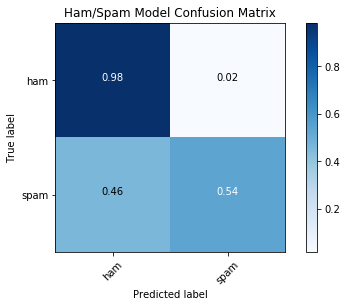

In [42]:
plot_tools.plot_confusion(labels_test, labels_pred, classes, title)

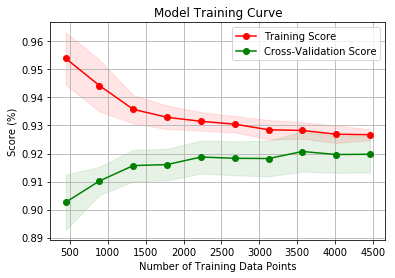

In [39]:
plot_tools.plot_learning(inputs, labels)

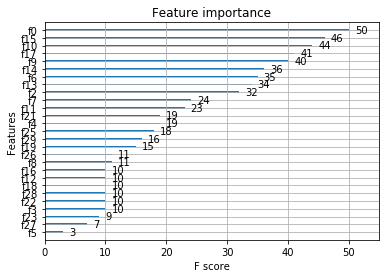

In [67]:
ax = plot_importance(tfidf_model)

I will grab the indecies for the best features and save them for later

In [ ]:
#0, 15, 10, 17, 9, 14, 6, 13, 2 
x = [0, 15, 10, 17, 9, 14, 6, 13, 2]
tfidf_indecies = sorted(x)

The next step is to explore the data. I am interested in features relating to capitalization and to punctuation. I want to explore these aspects of the data. 

Grab the capitalization information:

In [5]:
total_percent_capitalized = {}
percents = {}
total_words = {}
for key in data:
    total_percent_capitalized[key], percents[key], total_words[key] = utils.capitalized_statistics(data[key])    

Grab the punctuation information:

In [6]:
numbers = {"ham": None, "spam": None}
punctuation_marks = ["'", "?", "!", ".", ":"]
for key in data:
    for sentance in data[key]:
        numbers[key] = utils.get_punctuation(sentance, punctuation_marks, numbers[key])
        

Plots of capitalization information:

In [7]:
for key in data:
    print("Number of {0} messages: {1}".format(key, len(data[key])))
    print("Percent of {0} message words that were capitalized: {1}".format(key, total_percent_capitalized[key]))

Number of ham messages: 4827
Percent of ham message words that were capitalized: 0.183269124931
Number of spam messages: 747
Percent of spam message words that were capitalized: 0.287929683126


There are more words in ham messages this will cause us to overfit, which is seen in the confusion matrix above.

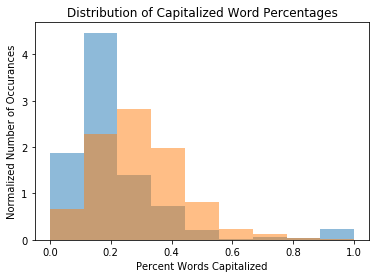

In [9]:
percents_bins = numpy.linspace(0, 1, 10)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)

ax.hist(percents["ham"], bins=percents_bins, alpha=0.5, label="ham", normed=True)
ax.hist(percents["spam"], bins=percents_bins, alpha=0.5, label="spam", normed=True)
ax.set_xlabel("Percent Words Capitalized")
ax.set_ylabel("Normalized Number of Occurances")
ax.set_title("Distribution of Capitalized Word Percentages")

fig.canvas.draw()
matplotlib.pyplot.show()

Plots of punctuation information:

Again, there may be more ham messages in the data, so we can divide by the number of messages and re-plot

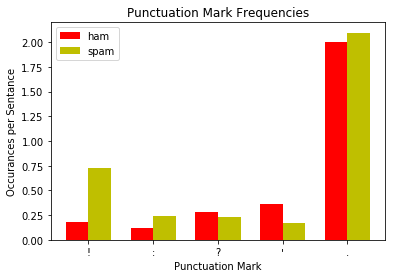

In [10]:
ham_punct = [float(numbers["ham"][key])/len(data["ham"]) for key in numbers["ham"]]
spam_punct = [float(numbers["spam"][key])/len(data["spam"]) for key in numbers["spam"]]

ind = numpy.arange(len(ham_punct))
width = 0.35

fig, ax = matplotlib.pyplot.subplots()
rects1 = ax.bar(ind, ham_punct, width, color='r')
rects2 = ax.bar(ind + width, spam_punct, width, color='y')

ax.set_title("Punctuation Mark Frequencies")
ax.set_ylabel('Occurances per Sentance')
ax.set_xlabel('Punctuation Mark')
ax.labelsize = "large"

# add some text for labels, title and axes ticks
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([key for key in numbers["spam"]])

ax.legend((rects1[0], rects2[0]), ('ham', 'spam'))
matplotlib.pyplot.show()

It looks like "!" is the best indicator of a spam message according to the given data. "." is not as good as it seemed simply because of the number of ham messages in the data is larger than the number of spam messages in the data. 

Now I will create a model. It will be simple as I only have a few features to work with for now.

Features to start with:
* Fraction of words capitalized < or > 0.2
* Number of occurances of !
* Number of occurances of :
* Number of occurances pf '

In [11]:
test_size = 0.20
features_matrix = numpy.ndarray((0, 5,), dtype=object)
labels = numpy.ndarray((0,), dtype=object)
for key in data:
    for message in data[key]:
        #the punctuation marks used are hidden in the utils.features() function
        feats = utils.features(message)
        features_matrix = numpy.vstack((features_matrix, feats))
        labels = numpy.append(labels, key)

Use the hand-picked features to create a model:

In [12]:
hand_model = utils.split_train(features_matrix, labels)

NameError: global name 'accuracy_score' is not defined

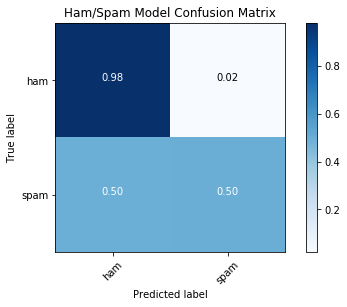

In [44]:
classes = ["ham", "spam"]
title = "Ham/Spam Model Confusion Matrix"
plot_tools.plot_confusion(labels_test, labels_pred, classes, title)

This shows that our data is limited as we are overfitting to the ham type messages because we have so many more.

Now I want to try to look at the learning curve of the data.

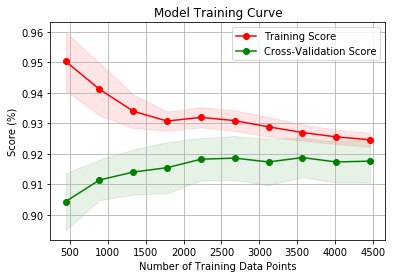

In [33]:
plot_tools.plot_learning(features_matrix, labels)

The test scores are plateuing meaning that a larger data set would have diminishing returns on improving the results.

Lastly, look at feature importance:

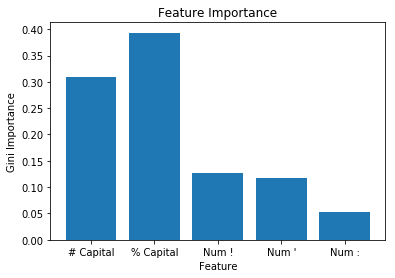

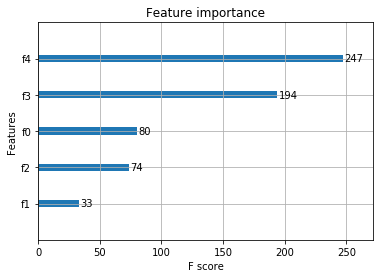

In [34]:
feature_names = ["Num !", "Num :", "Num '", "# Capital", "% Capital"]
matplotlib.pyplot.bar(feature_names, model.feature_importances_)
matplotlib.pyplot.xlabel("Feature")
matplotlib.pyplot.ylabel("Gini Importance")
matplotlib.pyplot.title("Feature Importance")

matplotlib.pyplot.show()

ax = plot_importance(model)

In [45]:
best_features_matrix = numpy.array([list(features_matrix[i]) + list(inputs[i][j] for j in tfidf_indecies) \
                                                    for i in range(len(features_matrix))])

In [1]:
best_model = utils.split_train(best_features_matrix, labels)

NameError: name 'utils' is not defined

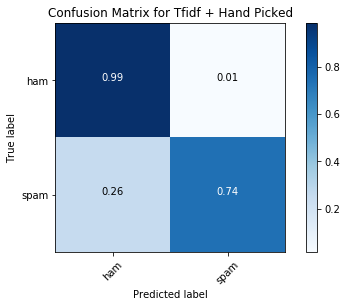

In [49]:
title = "Confusion Matrix for Tfidf + Hand Picked"
plot_tools.plot_confusion(labels_test, labels_pred, classes, title=title)

We still clearly are overfitting to the ham data, this is because we have ~7 times more ham than spam data; however, this algorithm is significantly better at classifying spam data.

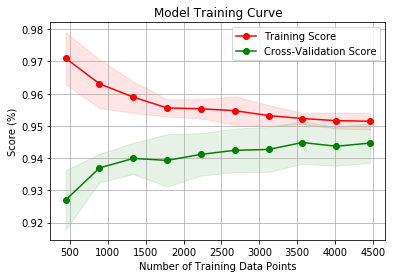

In [47]:
plot_tools.plot_learning(best_features_matrix, labels)

The performance here is from the decrease in confusing spam for ham messages. The gap is still about 1% which means the model will generalize reasonably well.